In [5]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [6]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   caltanissetta
   2   pistoia
   3   reggio_di_calabria
   4   lecco
   5   imperia
   6   milano
   7   taranto
   8   novara
   9   fermo
   10   belluno
   11   livorno
   12   parma
   13   lucca
   14   brescia
   15   viterbo
   16   brindisi
   17   teramo
   18   verona
   19   campobasso
   20   foggia
   21   enna
   22   perugia
   23   pesaro
   24   nuoro
   25   rimini
   26   bolzano
   27   vercelli
   28   rieti
   29   biella
   30   messina
   31   potenza
   32   chieti
   33   ferrara
   34   savona
   35   rovigo
   36   padova
   37   ancona
   38   la_spezia
   39   benevento
   40   sassari
   41   como
   42   bari
   43   caserta
   44   siracusa
   45   cremona
   46   monza
   47   gorizia
   48   terni
   49   massa
   50   arezzo
   51   napoli
   52   vibo_valentia
   53   cosenza
   54   lodi
   55   matera
   56   macerata
   57   catania
   58   sondrio
   59   ascoli_pice

In [7]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    #if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    #if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 pistoia
2 reggio_di_calabria
3 lecco
4 milano
5 taranto
6 novara
7 belluno
8 livorno
9 parma
10 lucca
11 brescia
12 viterbo
13 brindisi
14 teramo
15 verona
16 foggia
17 enna
18 perugia
19 pesaro
20 nuoro
21 rimini
22 vercelli
23 rieti
24 biella
25 potenza
26 chieti
27 ferrara
28 savona
29 rovigo
30 padova
31 ancona
32 la_spezia
33 benevento
34 sassari
35 como
36 bari
37 caserta
38 cremona
39 monza
40 gorizia
41 terni
42 massa
43 arezzo
44 napoli
45 vibo_valentia
46 cosenza
47 lodi
48 matera
49 macerata
50 catania
51 sondrio
52 ascoli_piceno
53 vicenza
54 reggio_nell_emilia
55 pavia
56 l_aquila
57 prato
58 venezia
59 pescara
60 salerno
61 pisa
62 agrigento
63 forli
64 mantova
65 udine
66 asti
67 avellino
68 siena
69 alessandria
70 crotone
71 piacenza
72 firenze
73 varese
74 lecce
75 modena
76 torino
77 ravenna
78 roma
79 cuneo
80 catanzaro
81 pordenone
82 trento
83 trieste
84 grosseto
85 bologna
86 oristano
87 bergamo
88 bat
89 palermo
90 genova
91 latina
92 frosinone
93 treviso
94 ca

In [8]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Using:         

Training set average RMSE:  0.36174  0.02143 
    Test set average RMSE:  0.95034  0.09242 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36214
                       R2:  0.93757


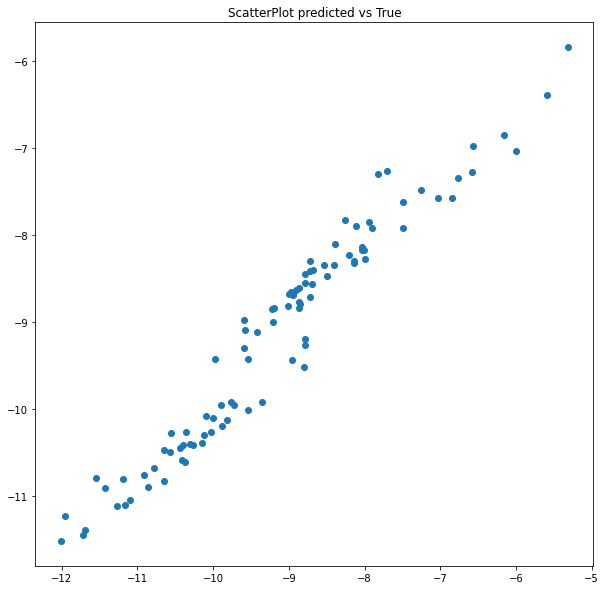

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03003
Feature:               commutersdensity, Score: 0.01550
Feature:                         depriv, Score: 0.02387
Feature:                            lat, Score: 0.62727
Feature:                 Ratio0200ver65, Score: 0.06813
Feature:           avg_wco_period1_2020, Score: 0.02601
Feature:          avg_wnh3_period1_2020, Score: 0.07731
Feature:           avg_wno_period1_2020, Score: 0.03849
Feature:           avg_wo3_period1_2020, Score: 0.04462
Feature:         avg_wpans_period1_2020, Score: 0.02609
Feature:          avg_wso2_period1_2020, Score: 0.02268


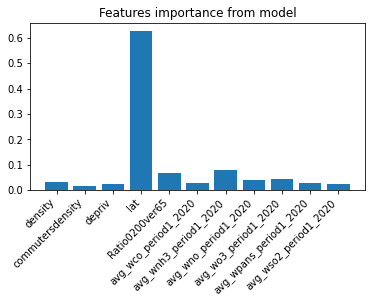

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04538
Feature:               commutersdensity, Score: 0.03669
Feature:                         depriv, Score: 0.04045
Feature:                            lat, Score: 2.77978
Feature:                 Ratio0200ver65, Score: 0.14449
Feature:           avg_wco_period1_2020, Score: 0.03918
Feature:          avg_wnh3_period1_2020, Score: 0.18961
Feature:           avg_wno_period1_2020, Score: 0.14888
Feature:           avg_wo3_period1_2020, Score: 0.08222
Feature:         avg_wpans_period1_2020, Score: 0.03897
Feature:          avg_wso2_period1_2020, Score: 0.05914


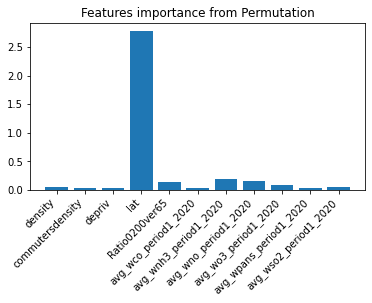

<Figure size 720x720 with 0 Axes>

((0.3617369626590613, 0.021425397796726548),
 (0.9503438410324461, 0.09241999178329507),
 0.3621397346333396,
 {'density': 0.012589117286573432,
  'commutersdensity': 0.01017872390343856,
  'depriv': 0.011222131682164987,
  'lat': 0.7711317132676264,
  'Ratio0200ver65': 0.04008281056749117,
  'avg_wco_period1_2020': 0.01086905013525976,
  'avg_wnh3_period1_2020': 0.052599973753674326,
  'avg_wno_period1_2020': 0.04130181950733254,
  'avg_wo3_period1_2020': 0.022808072658344846,
  'avg_wpans_period1_2020': 0.010811352904526018,
  'avg_wso2_period1_2020': 0.01640523433356784})

In [9]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

Training set average RMSE:  0.37868  0.02847 
    Test set average RMSE:  1.04789  0.11595 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37488
                       R2:  0.93310


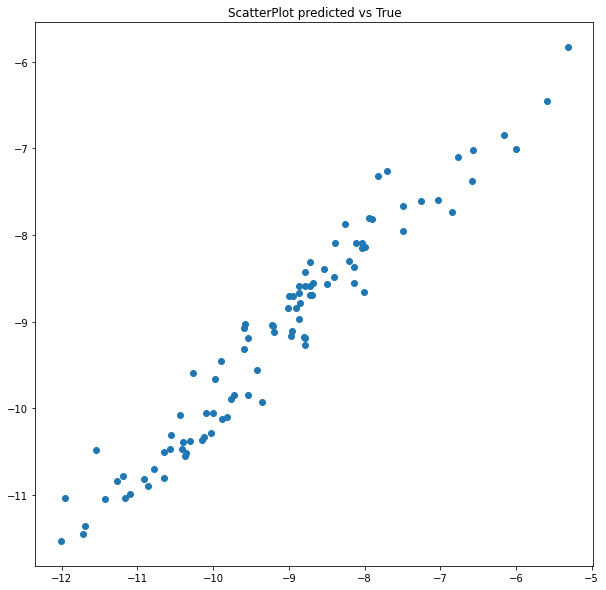

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03263
Feature:               commutersdensity, Score: 0.44280
Feature:                         depriv, Score: 0.03093
Feature:                 Ratio0200ver65, Score: 0.07938
Feature:           avg_wco_period1_2020, Score: 0.05388
Feature:          avg_wnh3_period1_2020, Score: 0.09598
Feature:           avg_wno_period1_2020, Score: 0.13338
Feature:           avg_wo3_period1_2020, Score: 0.05354
Feature:         avg_wpans_period1_2020, Score: 0.03477
Feature:          avg_wso2_period1_2020, Score: 0.04270


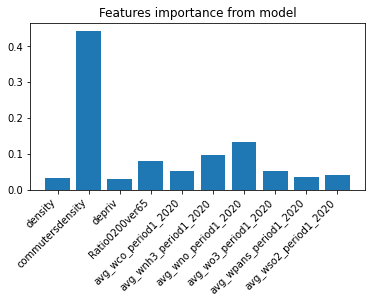

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.06227
Feature:               commutersdensity, Score: 1.38054
Feature:                         depriv, Score: 0.05688
Feature:                 Ratio0200ver65, Score: 0.15324
Feature:           avg_wco_period1_2020, Score: 0.11884
Feature:          avg_wnh3_period1_2020, Score: 0.20333
Feature:           avg_wno_period1_2020, Score: 0.33459
Feature:           avg_wo3_period1_2020, Score: 0.08207
Feature:         avg_wpans_period1_2020, Score: 0.06054
Feature:          avg_wso2_period1_2020, Score: 0.07414


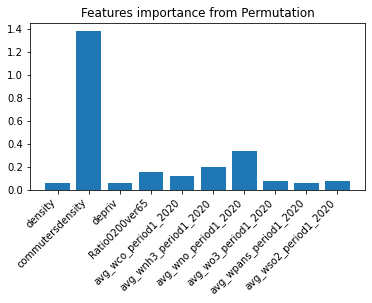

<Figure size 720x720 with 0 Axes>

((0.378680992598966, 0.02847354607368273),
 (1.0478872821272542, 0.11595179631007427),
 0.37488392592550696,
 {'density': 0.024648345737391237,
  'commutersdensity': 0.5464376889957206,
  'depriv': 0.022512967593431143,
  'Ratio0200ver65': 0.06065562108444215,
  'avg_wco_period1_2020': 0.04703749136469546,
  'avg_wnh3_period1_2020': 0.08047898507553251,
  'avg_wno_period1_2020': 0.13243556059570802,
  'avg_wo3_period1_2020': 0.03248437586585827,
  'avg_wpans_period1_2020': 0.023962437746440943,
  'avg_wso2_period1_2020': 0.029346525940779796})

In [10]:
featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

Training set average RMSE:  0.39871  0.02276 
    Test set average RMSE:  1.05398  0.11878 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38201
                       R2:  0.93054


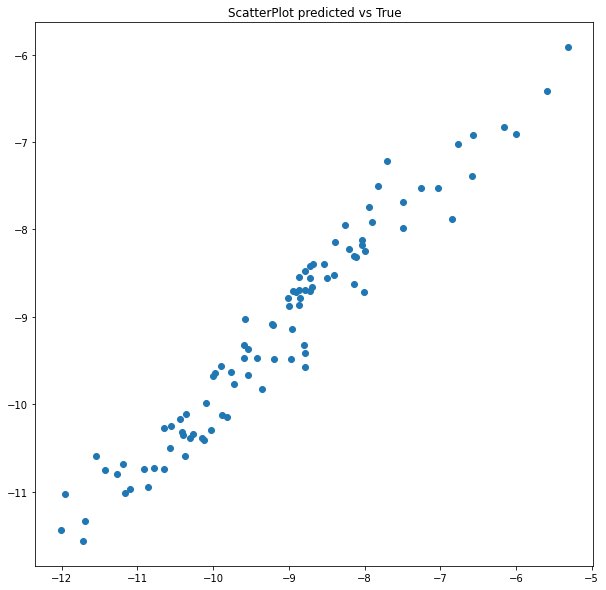

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03403
Feature:                         depriv, Score: 0.22713
Feature:                 Ratio0200ver65, Score: 0.08103
Feature:           avg_wco_period1_2020, Score: 0.09642
Feature:          avg_wnh3_period1_2020, Score: 0.12955
Feature:           avg_wno_period1_2020, Score: 0.28431
Feature:           avg_wo3_period1_2020, Score: 0.05284
Feature:         avg_wpans_period1_2020, Score: 0.04682
Feature:          avg_wso2_period1_2020, Score: 0.04788


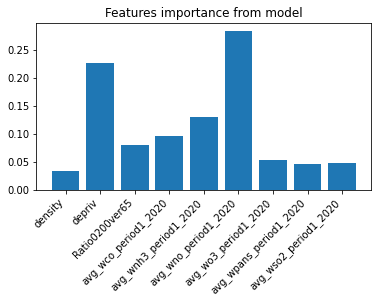

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.07860
Feature:                         depriv, Score: 0.65963
Feature:                 Ratio0200ver65, Score: 0.11539
Feature:           avg_wco_period1_2020, Score: 0.15279
Feature:          avg_wnh3_period1_2020, Score: 0.26726
Feature:           avg_wno_period1_2020, Score: 0.66865
Feature:           avg_wo3_period1_2020, Score: 0.08512
Feature:         avg_wpans_period1_2020, Score: 0.10429
Feature:          avg_wso2_period1_2020, Score: 0.11096


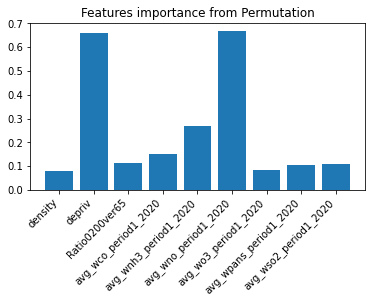

<Figure size 720x720 with 0 Axes>

((0.39871403164233776, 0.022761407618994988),
 (1.0539807602107272, 0.11878305214704157),
 0.3820096653818022,
 {'density': 0.03504852029570584,
  'depriv': 0.2941242509595023,
  'Ratio0200ver65': 0.05145255841011266,
  'avg_wco_period1_2020': 0.0681265595339775,
  'avg_wnh3_period1_2020': 0.11917053930143404,
  'avg_wno_period1_2020': 0.2981456772604751,
  'avg_wo3_period1_2020': 0.037953138392271255,
  'avg_wpans_period1_2020': 0.046503182449818166,
  'avg_wso2_period1_2020': 0.04947557339670344})

In [12]:
featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y)

print(bestf, bestmse)

1  of  2400 MSE:  0.13114518740030562
2  of  2400 MSE:  0.10776258031609456
3  of  2400 MSE:  9.221420851522872e-10
4  of  2400 MSE:  3.6885683402629455e-13
5  of  2400 MSE:  0.18713216509187885
6  of  2400 MSE:  0.22148643268010887
7  of  2400 MSE:  0.1060713839357641
8  of  2400 MSE:  0.05579837255038529
9  of  2400 MSE:  0.4240662519577653
10  of  2400 MSE:  0.5240089310643928
11  of  2400 MSE:  0.3287722699864988
12  of  2400 MSE:  0.30741201621078623
13  of  2400 MSE:  0.6094058765034807
14  of  2400 MSE:  0.6796297461914398
15  of  2400 MSE:  0.5907794231348683
16  of  2400 MSE:  0.5686811139890472
17  of  2400 MSE:  0.179794320710128
18  of  2400 MSE:  0.19214744930495617
19  of  2400 MSE:  0.08277274830190558
20  of  2400 MSE:  0.04307056305799653
21  of  2400 MSE:  0.21018315907811197
22  of  2400 MSE:  0.25521879699537653
23  of  2400 MSE:  0.11858347345780404
24  of  2400 MSE:  0.06862085993101681
25  of  2400 MSE:  0.4240662519577653
26  of  2400 MSE:  0.5240089310643928
27

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 1}
Training set average RMSE:  0.00000  0.00000 
    Test set average RMSE:  0.98680  0.10450 
Parameters used: 
{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.00000
                       R2:  1.00000


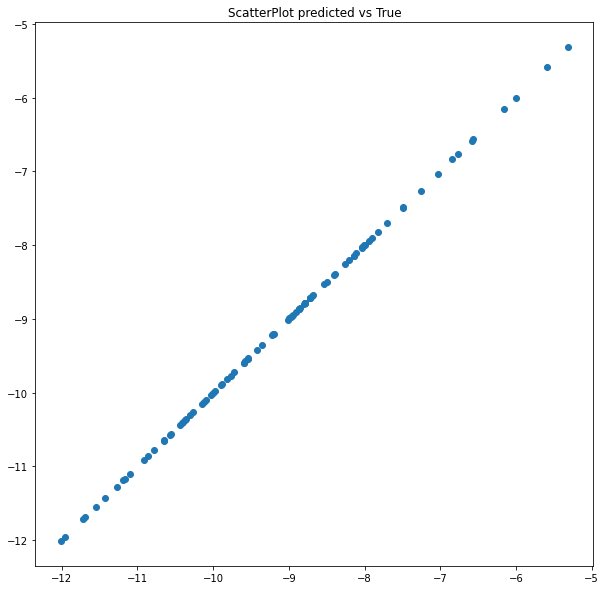

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03636
Feature:               commutersdensity, Score: 0.15626
Feature:                         depriv, Score: 0.05876
Feature:                            lat, Score: 0.22870
Feature:                 Ratio0200ver65, Score: 0.05132
Feature:           avg_wco_period1_2020, Score: 0.10546
Feature:          avg_wnh3_period1_2020, Score: 0.08843
Feature:           avg_wno_period1_2020, Score: 0.13350
Feature:           avg_wo3_period1_2020, Score: 0.06217
Feature:         avg_wpans_period1_2020, Score: 0.03286
Feature:          avg_wso2_period1_2020, Score: 0.04619


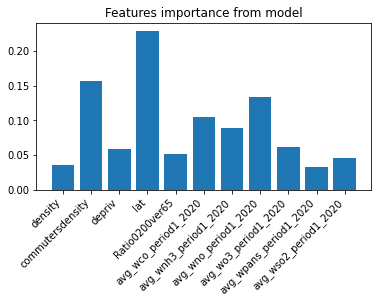

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04565
Feature:               commutersdensity, Score: 0.04158
Feature:                         depriv, Score: 0.05503
Feature:                            lat, Score: 2.73256
Feature:                 Ratio0200ver65, Score: 0.14426
Feature:           avg_wco_period1_2020, Score: 0.07345
Feature:          avg_wnh3_period1_2020, Score: 0.17120
Feature:           avg_wno_period1_2020, Score: 0.13220
Feature:           avg_wo3_period1_2020, Score: 0.07484
Feature:         avg_wpans_period1_2020, Score: 0.05068
Feature:          avg_wso2_period1_2020, Score: 0.04593


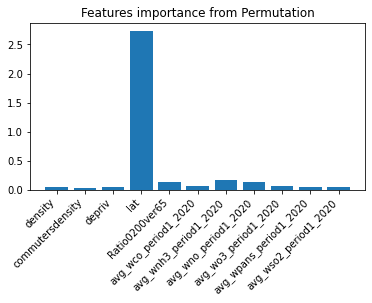

<Figure size 720x720 with 0 Axes>

((9.293963532648301e-07, 1.4628397282942013e-06),
 (0.9868003459720804, 0.1044997927866404),
 5.06531333011437e-07,
 {'density': 0.012795567001306036,
  'commutersdensity': 0.011654965405143415,
  'depriv': 0.015426486772267796,
  'lat': 0.7659868117650079,
  'Ratio0200ver65': 0.04043845238569215,
  'avg_wco_period1_2020': 0.02058901042001774,
  'avg_wnh3_period1_2020': 0.047990004195600566,
  'avg_wno_period1_2020': 0.03705920334032787,
  'avg_wo3_period1_2020': 0.020978435418410993,
  'avg_wpans_period1_2020': 0.014205403045835712,
  'avg_wso2_period1_2020': 0.012875660250390056})

In [16]:
#importlib.reload(smlmodule)
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)

In [17]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.13114518740030562
2  of  1200 MSE:  0.10776258031609456
3  of  1200 MSE:  0.18713216509187885
4  of  1200 MSE:  0.22148643268010887
5  of  1200 MSE:  0.4240662519577653
6  of  1200 MSE:  0.5240089310643928
7  of  1200 MSE:  0.6094058765034807
8  of  1200 MSE:  0.6796297461914398
9  of  1200 MSE:  0.179794320710128
10  of  1200 MSE:  0.19214744930495617
11  of  1200 MSE:  0.21018315907811197
12  of  1200 MSE:  0.25521879699537653
13  of  1200 MSE:  0.4240662519577653
14  of  1200 MSE:  0.5240089310643928
15  of  1200 MSE:  0.6094058765034807
16  of  1200 MSE:  0.6796297461914398
17  of  1200 MSE:  0.2894848642421291
18  of  1200 MSE:  0.33968653780029157
19  of  1200 MSE:  0.31728330116390707
20  of  1200 MSE:  0.3948883398403591
21  of  1200 MSE:  0.4240662519577653
22  of  1200 MSE:  0.5240089310643928
23  of  1200 MSE:  0.6094058765034807
24  of  1200 MSE:  0.6796297461914398
25  of  1200 MSE:  0.378370660384312
26  of  1200 MSE:  0.43426301946921264
27  of  1200 

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 1}
Training set average RMSE:  0.34985  0.02589 
    Test set average RMSE:  0.96495  0.10893 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32754
                       R2:  0.94893


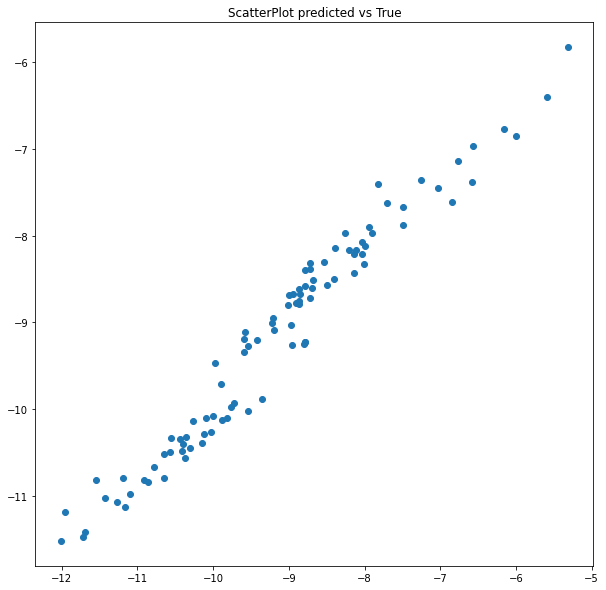

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02708
Feature:               commutersdensity, Score: 0.14615
Feature:                         depriv, Score: 0.07277
Feature:                            lat, Score: 0.24929
Feature:                 Ratio0200ver65, Score: 0.05744
Feature:           avg_wco_period1_2020, Score: 0.10150
Feature:          avg_wnh3_period1_2020, Score: 0.09883
Feature:           avg_wno_period1_2020, Score: 0.12015
Feature:           avg_wo3_period1_2020, Score: 0.05765
Feature:         avg_wpans_period1_2020, Score: 0.03336
Feature:          avg_wso2_period1_2020, Score: 0.03578


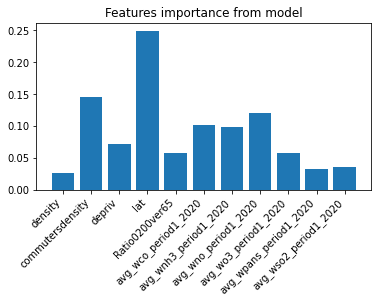

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04783
Feature:               commutersdensity, Score: 0.02746
Feature:                         depriv, Score: 0.03905
Feature:                            lat, Score: 2.66394
Feature:                 Ratio0200ver65, Score: 0.11326
Feature:           avg_wco_period1_2020, Score: 0.05982
Feature:          avg_wnh3_period1_2020, Score: 0.21389
Feature:           avg_wno_period1_2020, Score: 0.11826
Feature:           avg_wo3_period1_2020, Score: 0.06885
Feature:         avg_wpans_period1_2020, Score: 0.05203
Feature:          avg_wso2_period1_2020, Score: 0.06458


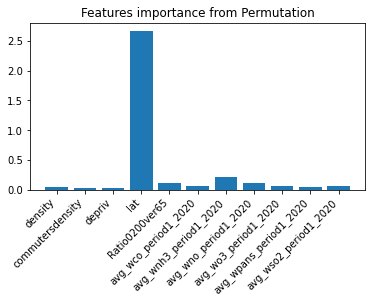

<Figure size 720x720 with 0 Axes>

((0.34985051550745516, 0.02589103481234869),
 (0.9649549444455707, 0.10893073378957162),
 0.32753641813263645,
 {'density': 0.013787311543449565,
  'commutersdensity': 0.007915387106045939,
  'depriv': 0.011256933522712145,
  'lat': 0.7679338828460756,
  'Ratio0200ver65': 0.03264956608732105,
  'avg_wco_period1_2020': 0.017245129121696286,
  'avg_wnh3_period1_2020': 0.061659529984432804,
  'avg_wno_period1_2020': 0.034090376168302,
  'avg_wo3_period1_2020': 0.019847603719393005,
  'avg_wpans_period1_2020': 0.014998005244203158,
  'avg_wso2_period1_2020': 0.018616274656368285})

In [18]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)